In [6]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!pip install drive

In [8]:
import drive

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json


In [14]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 99% 1.01G/1.03G [00:07<00:00, 40.2MB/s]
100% 1.03G/1.03G [00:07<00:00, 146MB/s] 


In [15]:
!unzip asl-alphabet.zip -d asl-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alp

In [16]:
!pip install imutils

In [17]:
import warnings

In [18]:
warnings.filterwarnings("ignore")

In [19]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
import tensorflow as tf


In [22]:
!pip install keras

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator # Corrected import
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:
class CFG:
  batch_size = 64
  img_height = 64
  img_width = 64
  epochs = 10
  num_classes = 29
  img_channels = 3

def seed_everything(seed: int):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

In [25]:
# labels

TRAIN_PATH = "asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [26]:
# create metadata
list_path = []
list_labels = []
for label in labels:
  label_path = os.path.join(TRAIN_PATH, label, "*")
  image_files = glob.glob(label_path)

  sign_label = [label] * len(image_files)

  list_path.extend(image_files)
  list_labels.extend(sign_label)

# Create the DataFrame after the loop
metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})
display(metadata.head()) # Display the head to check if it's populated

,image_path,label
0,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
1,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
2,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
3,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
4,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A


In [27]:
# split dataset to 70 % train, 15 % val, 15 % test
X_train, X_test, Y_train, Y_test = train_test_split(
    metadata["image_path"],
    metadata["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({"image_path": X_train, "label": Y_train})

X_train, X_val, Y_train, Y_val = train_test_split(
    data_train["image_path"],
    data_train["label"],
    test_size=0.15 / 0.85,      # 0.15 of the original total
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)

data_train = pd.DataFrame({"image_path": X_train, "label": Y_train})
data_val   = pd.DataFrame({"image_path": X_val,   "label": Y_val})
data_test  = pd.DataFrame({"image_path": X_test,  "label": Y_test})


In [28]:
# data augmentation

def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.)

    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory=".",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width)
    )

    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory=".",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width)
    )

    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory=".",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [29]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()


Found 60900 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │        14,87

 Total params: 15,385,693 (58.69 MB)

 Trainable params: 671,005 (2.56 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

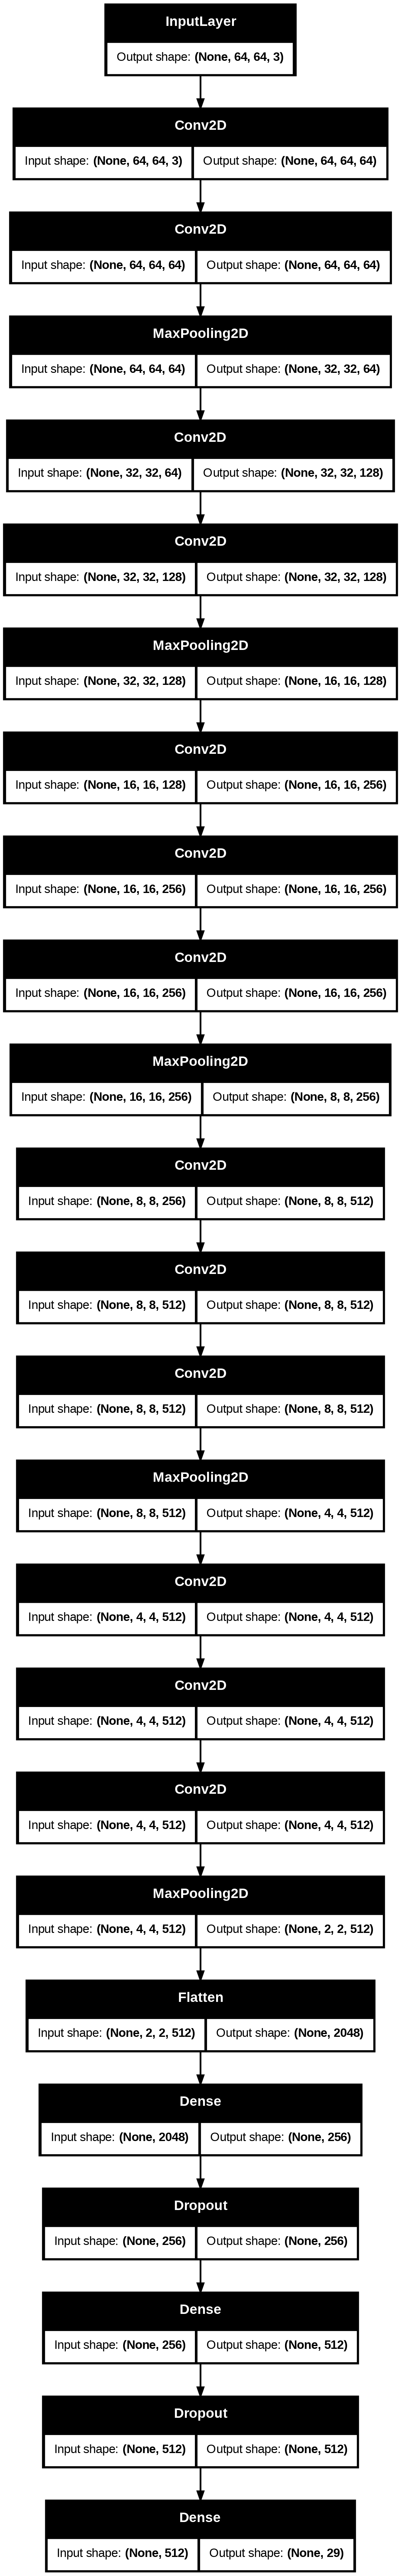

In [30]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples,
    epochs= CFG.epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples,
    callbacks = [checkpoint ]
)

Epoch 1/10
  951/60900 ━━━━━━━━━━━━━━━━━━━━ 55:31 56ms/step - accuracy: 0.4095 - loss: 1.9726
Epoch 1: val_accuracy improved from -inf to 0.92215, saving model to asl_vgg16_best_weights.h5


60900/60900 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 0.5981 - loss: 1.2688 - val_accuracy: 0.9221 - val_loss: 0.2938
Epoch 2/10
  951/60900 ━━━━━━━━━━━━━━━━━━━━ 51:24 51ms/step - accuracy: 0.8166 - loss: 0.5357
Epoch 2: val_accuracy improved from 0.92215 to 0.96690, saving model to asl_vgg16_best_weights.h5


60900/60900 ━━━━━━━━━━━━━━━━━━━━ 59s 970us/step - accuracy: 0.8349 - loss: 0.4818 - val_accuracy: 0.9669 - val_loss: 0.1304
Epoch 3/10
  952/60900 ━━━━━━━━━━━━━━━━━━━━ 50:06 50ms/step - accuracy: 0.8716 - loss: 0.3744
Epoch 3: val_accuracy improved from 0.96690 to 0.97402, saving model to asl_vgg16_best_weights.h5


60900/60900 ━━━━━━━━━━━━━━━━━━━━ 81s 950us/step - accuracy: 0.8764 - loss: 0.3605 - val_accuracy: 0.9740 - val_loss: 0.0990
Epoch 4/10
  952/60900 ━━━━━━━━━━━━━━━━━━━━ 51:08 51ms/step - accuracy: 0.8893 - loss: 0.3197
Epoch 4: val_accuracy improved from 0.97402 to 0.98130, saving model to asl_vgg16_best_weights.h5


60900/60900 ━━━━━━━━━━━━━━━━━━━━ 82s 956us/step - accuracy: 0.8933 - loss: 0.3085 - val_accuracy: 0.9813 - val_loss: 0.0726
Epoch 5/10
  952/60900 ━━━━━━━━━━━━━━━━━━━━ 49:33 50ms/step - accuracy: 0.9075 - loss: 0.2668
Epoch 5: val_accuracy did not improve from 0.98130
60900/60900 ━━━━━━━━━━━━━━━━━━━━ 57s 938us/step - accuracy: 0.9062 - loss: 0.2730 - val_accuracy: 0.9770 - val_loss: 0.0787
Epoch 6/10
  951/60900 ━━━━━━━━━━━━━━━━━━━━ 49:58 50ms/step - accuracy: 0.9159 - loss: 0.2388
Epoch 6: val_accuracy improved from 0.98130 to 0.98920, saving model to asl_vgg16_best_weights.h5


60900/60900 ━━━━━━━━━━━━━━━━━━━━ 58s 950us/step - accuracy: 0.9168 - loss: 0.2402 - val_accuracy: 0.9892 - val_loss: 0.0422
Epoch 7/10
  952/60900 ━━━━━━━━━━━━━━━━━━━━ 50:01 50ms/step - accuracy: 0.9203 - loss: 0.2303
Epoch 7: val_accuracy did not improve from 0.98920
60900/60900 ━━━━━━━━━━━━━━━━━━━━ 57s 939us/step - accuracy: 0.9184 - loss: 0.2338 - val_accuracy: 0.9846 - val_loss: 0.0484
Epoch 8/10
  952/60900 ━━━━━━━━━━━━━━━━━━━━ 50:15 50ms/step - accuracy: 0.9249 - loss: 0.2152
Epoch 8: val_accuracy did not improve from 0.98920
60900/60900 ━━━━━━━━━━━━━━━━━━━━ 58s 950us/step - accuracy: 0.9238 - loss: 0.2205 - val_accuracy: 0.9865 - val_loss: 0.0483
Epoch 9/10
  951/60900 ━━━━━━━━━━━━━━━━━━━━ 49:46 50ms/step - accuracy: 0.9270 - loss: 0.2111
Epoch 9: val_accuracy did not improve from 0.98920
60900/60900 ━━━━━━━━━━━━━━━━━━━━ 81s 941us/step - accuracy: 0.9316 - loss: 0.1976 - val_accuracy: 0.9849 - val_loss: 0.0495
Epoch 10/10
  952/60900 ━━━━━━━━━━━━━━━━━━━━ 48:49 49ms/step - accura

In [37]:
fine_tuned_model = load_model('asl_vgg16_best_weights.h5')
predictions = fine_tuned_model.predict(test_generator)

true_labels = test_generator.classes

confusion_matrix = tf.math.confusion_matrix(
    labels=true_labels,
    predictions=predictions.argmax(axis=1),
    num_classes=29
)


204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step


In [42]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-2].output)
dense_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,370,816 (58.64 MB)

 Trainable params: 656,128 (2.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
def dense_feature_prediction(img_path):
  # Add a check to ensure img_path is a string
  if not isinstance(img_path, str):
      # Handle the case where the input is not a string,
      # for example, return None or raise a more informative error
      print(f"Warning: Expected string path, but received type: {type(img_path)}. Skipping.")
      return None # Or handle appropriately

  img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
  img = img_to_array(img)
  img = img / 255.
  img = np.expand_dims(img, axis=0)
  dense_feature = dense_model.predict(img, verbose=0)[0]
  return dense_feature

reduction_data = pd.DataFrame()
list_of_dfs = [] # Create a list to store DataFrames for each label

for label in labels:
  label_data = data_test[data_test["label"]==label][:100]
  list_of_dfs.append(label_data) # Append the DataFrame for the current label

# Concatenate all the DataFrames in the list
reduction_data = pd.concat(list_of_dfs, ignore_index=True)

display(reduction_data)

dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
# Drop rows where dense_feature_prediction returned None (due to invalid path)
dense_features = dense_features.dropna()
dense_features = pd.DataFrame.from_records(dense_features.values.tolist(), index=dense_features.index)

,image_path,label
0,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
1,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
2,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
3,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
4,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A
...,...,...
2895,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space
2896,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space
2897,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space
2898,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space


100%|██████████| 2900/2900 [04:33<00:00, 10.60it/s]


In [51]:
tsne = TSNE(n_components=2, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=['tsne_feat_0', 'tsne_feat_1'])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

,image_path,label,tsne_feat_0,tsne_feat_1
0,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A,-10.303506,10.186443
1,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A,1.130126,12.439118
2,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A,1.387749,11.921980
3,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A,3.329643,11.825457
4,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,A,1.315405,11.772288
...,...,...,...,...
2895,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space,12.653522,-21.479074
2896,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space,9.659438,-24.056446
2897,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space,14.111387,-21.646288
2898,asl-alphabet/asl_alphabet_train/asl_alphabet_t...,space,8.511232,-23.792780


# LOADING AND TESTING THE MODEL!

In [55]:
model = tf.keras.models.load_model("/content/asl_vgg16_best_weights.h5")
image_path = '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))

img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

predictions = model.predict(np.array([img]))

predict_class = labels[np.argmax(predictions)]
print(f"The predicted class is: {predict_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
The predicted class is: A


### CNN MODEL

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

input_shape = (224, 224, 3)

inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(29, activation='softmax')(x)

custom_cnn_model = Model(inputs, outputs)

custom_cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,791,069 (98.39 MB)

 Trainable params: 25,791,069 (98.39 MB)

 Non-trainable params: 0 (0.00 B)